# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [17]:
# Change here using YOUR first and last names
fn1 = "antoine"
ln1 = "habis"
fn2 = "geert-jan"
ln2 = "huizing"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_habis_antoine_and_huizing_geert-jan.ipynb


In [18]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm, svd

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

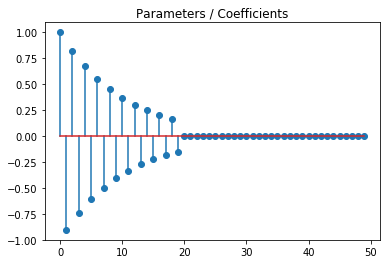

In [20]:
n_features = 50
n_samples = 1000

idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.

plt.stem(coefs)
plt.title("Parameters / Coefficients")
plt.show()

### Functions for the simulation of the models

In [23]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [24]:
# A, b = simu_linreg(coefs);
# uncomment when you want to test logistic regression
A, b = simu_logreg(coefs)

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

> *Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below*

In [26]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = (x - lmbd > 0)*(x - lmbd) + (x < -lmbd)*(x + lmbd)
    return z


def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * norm(x, 1)


def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x/(1+lmbd)
    return z


def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return (lmbd/2)*norm(x)**2

> *Visualize the identity function and the proximity operators of the L2 and L1 on the real axis*

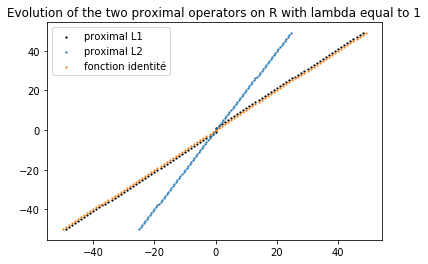

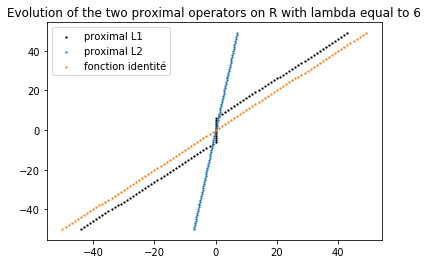

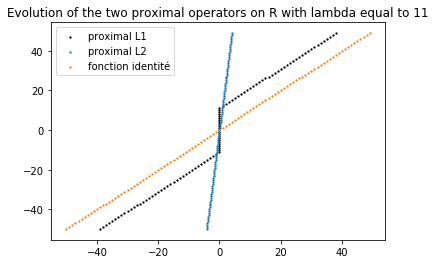

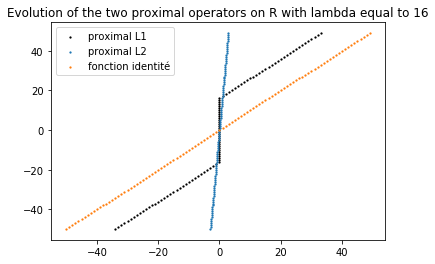

In [29]:
lmbda = np.arange(1,20,5)
x = np.arange(-50,50)

for lmbda_temp in lmbda:
    yprox_L2 = prox_L2(x,lmbda_temp)
    yprox_L1 = prox_L1(x,lmbda_temp)
    plt.scatter(yprox_L1, x,1.5,'k',label = 'proximal L1')
    plt.scatter(yprox_L2, x, 1.5, label = 'proximal L2')
    plt.scatter(x,x,1.5, label = 'fonction identité')
    plt.title('Evolution of the two proximal operators on R with lambda equal to '+ str(lmbda_temp))
    plt.legend()
    plt.show()

<div class="alert alert-info">
We can see that the identity function and the proximal operator for the L1 norm are really close. Actually it depends of the value of $\lambda$. If $\lambda$ is very big then the regularization term will prevalue on the first one and the curve will deviate from the identity curve. On the contrary if $\lambda$ decreases then the two functions get closer.
</div>



## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

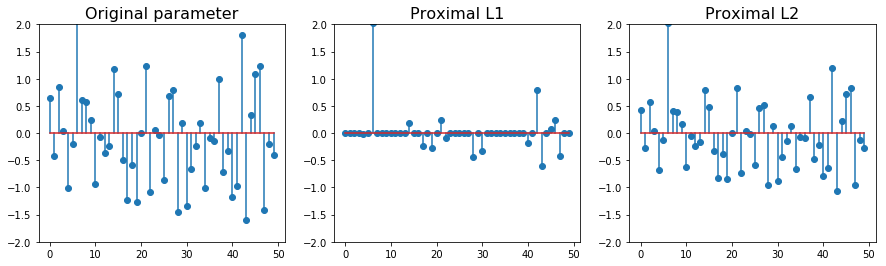

In [31]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])

plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])

plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

plt.show()

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-info">
We can see that the proximal operator L1 puts many coefficient to zero whereas the proximal operator L2 keep the same evolution of the 'original parameters' but they are resclaled by a factor of $\frac{1}{1+2\lambda}$. <br><br>

In the two cases the variance seems to be reduced because the coefficients are close to zero for the proximal L1 operator and for the proximal L2 the variance is reduced by a factor of $\frac{1}{{(1+2\lambda)}^{2}}$
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

> *Compute on paper the gradient  ∇f  of  f  for both cases (linear and logistic regression)*

**Linear regression**
\begin{equation}
\nabla f(x) = \nabla_{x} \frac{1}{2 n} \| b - A x \|_2^2\\
            = \frac{1}{2 n}\nabla_{x}\| b - A x \|_2^2\\
            = - \frac{1}{ n}A^{T}(b -Ax)\\
\end{equation}

**Logistic regression**

\begin{equation}
\nabla f(x) = \frac{1}{n} \sum_{i=1}^{n} \nabla_x \log(1 + \exp(-b_i a_i^T x))\\
            = \frac{1}{n} \sum_{i=1}^{n} \frac{-b_{i}a_{i}^{T}x}{1+e^{-b_{i}a_{i}^{T}x}}\end{equation}

> *Code a function that computes  f  and its gradient  ∇f  in both cases, using the prototypes below.*

In [34]:
def loss_linreg(x):
    """Least squares loss"""
    return (1/(2*n_samples))*norm(b-np.dot(A,x),2)**(2)
    pass

def grad_linreg(x):
    """Least squares gradient"""
    return -(1/n_samples)*np.dot(A.T,b-np.dot(A,x))
    pass

def loss_logreg(x):
    """Logistic loss"""
    Y = np.array([np.log(1 + np.exp(-np.dot(b[i]*A[i].reshape(1,-1),x))) for i in range (n_samples)])
    return (1/n_samples)*np.sum(Y)
    pass

def grad_logreg(x):
    d = x.shape[0]
    """Logistic gradient"""
    return (1/(n_samples))*np.sum(np.array([-b[i]*A[i].reshape(1,-1)*np.exp(np.dot(-b[i]*A[i].reshape(1,-1),x))/(1+np.exp(np.dot(-b[i]*A[i].reshape(1,-1),x))) for i in range (n_samples)]), axis = 0)[0]
    pass

> *Check that these functions are correct by numerically checking the gradient*

In [33]:
from scipy.optimize import check_grad
check_grad(loss_linreg, grad_linreg, randn(50))

4.5340173042133644e-06

## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

> *Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative*

<div class="alert alert-info">
**Linear Regression**<br><br>
Let's take $x_1$and $x_2$ two different vectors of $\mathbb{R^{d}}$ and compute the norm of the difference of the gradient .
\begin{equation}
    ||\nabla f(x_1) - \nabla f(x_2)|| = ||\frac{-1}{n} A^{T}A(x_1 -x_2)||\\
                                       \leq \frac{1}{n}|||A^T A|||\\
\end{equation}
<br><br>

However $A^TA$ is a symetric matrix so there exist $\Sigma$ a diagonal matrix and $W$ an orthogonal matrix such as:
$A^TA = W^T\Sigma W$<br><br>

Consequently:<br><br>

\begin{equation}
       sup_{X \in R^d} \frac{||A^TAX||}{||X||} = sup_{X \in \mathbb{R}^d} \frac{||W^T\Sigma WX||}{||X||}\\
                                            = sup_{X \in \mathbb{R}^d||X|| = 1}||\Sigma X||\\
                                            = \sigma_{max(A^TA)}
\end{equation}
    

$\sigma_{max(A^TA)}$ being the largest singular value of $A^TA$

the second equality stands because in the decomposition of $A^TA$ the product of a orthogonal matrix conserve the norm and $W$ is invertible. 

</div>

<div class="alert alert-info">

**Logistic Regression**<br><br>

$f(x) = \dfrac{1}{n}\sum_i\phi(b_ia_i^Tx)$ with :<br><br>

$\phi:t\mapsto \log (1 + e^{-t})$<br>
$\phi':t\mapsto -e^{-t}(1 + e^{-t})^{-1}$<br>
$\phi'':t\mapsto \dfrac{e^{-t}}{(1 + e^{-t})^2}$<br><br>

$U = e^{-t}$<br><br>

$U+\frac{1}{U} \geq 2$ because $(U-1)^2\geq 0$ $(1)$<br><br>

Or $\frac{U}{(1+U)^2} = \frac{1}{\frac{1}{U}+2+U} \leq \frac{1}{4}$ thanks to $(1)$

<br><br>

so $|\phi''| \leq \frac{1}{4}$.<br><br>

$\nabla f(x) = \dfrac{1}{n}\sum_i\phi'(b_ia_i^Tx)b_ia_i$

$\nabla^2 f(x)_{k, l} = \dfrac{1}{n}\sum_i\dfrac{\partial_k}{\partial x_l}(\phi'(b_ia_i^Tx)b_ia_i) = \dfrac{1}{n}\sum_ib_i^2a_{i, k}a_{i, l}\phi''(b_ia_i^Tx)$

$b_i^2=1$ and $a_{i, k}a_{i, l} = (a_ia_i^T)_{k, l}$ so :

$\nabla^2 f(x) = \dfrac{1}{n}\sum_ia_ia_i^T\phi''(b_ia_i^Tx) = \dfrac{1}{n}A^T\Sigma A~$ with $~\Sigma = diag~ \phi''(b_ia_i^Tx)$<br><br>

Consequently :<br><br>

$|||\nabla^2f(x)||| = |||\dfrac{1}{n}A^T\Sigma A||| \leq |||\dfrac{1}{n}A^T\dfrac{1}{4}I_n A|||$<br><br>

$|||\nabla^2f(x)||| \leq \dfrac{1}{4n}|||A^TA|||$<br><br>

Finally,

$$|||\nabla^2f(x)||| \leq \dfrac{\sigma_{max(A^TA)}}{4n}$$

</div>

> *Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression).*

In [35]:
# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""
    return np.linalg.svd(A.T @ A)[1][0]/A.shape[0]

# Calculate the smoothness constant for logistic loss
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""
    return .25*np.linalg.svd(A.T @ A)[1][0]/A.shape[0]

> *Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.*

In [13]:
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
        x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_R(x - step*grad_f(x), lmbd*step)

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        w = prox_R(z - step*grad_f(z), lmbd*step)
        t_new = (1 + np.sqrt(1 + 4*t*t))/2
        z = w + (w - x)*(t-1)/t_new
        
        x = w
        t = t_new

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % max(1, n_iter//10) == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [36]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.54e-01 | 9.32e-01
     100 | 5.64e-01 | 3.58e-01
     200 | 5.64e-01 | 3.58e-01
     300 | 5.64e-01 | 3.58e-01
     400 | 5.64e-01 | 3.58e-01
     500 | 5.64e-01 | 3.58e-01
     600 | 5.64e-01 | 3.58e-01
     700 | 5.64e-01 | 3.58e-01
     800 | 5.64e-01 | 3.58e-01
     900 | 5.64e-01 | 3.58e-01
    1000 | 5.64e-01 | 3.58e-01


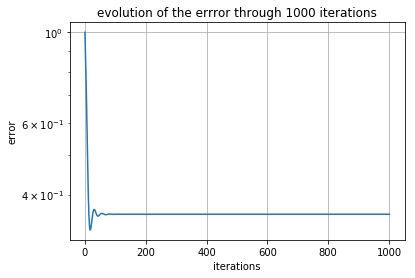

In [37]:
x, objectives, errors = APGD(x0, loss_logreg, grad_logreg,
                             L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                             lmbd, 1000, coefs, True)
plt.plot(errors)
plt.grid()
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('evolution of the errror through 1000 iterations')
plt.show()

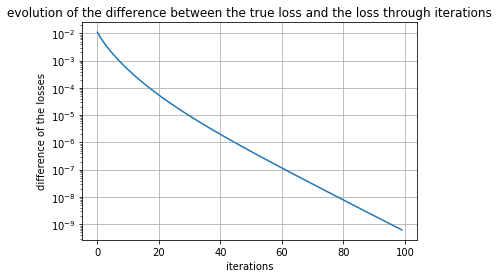

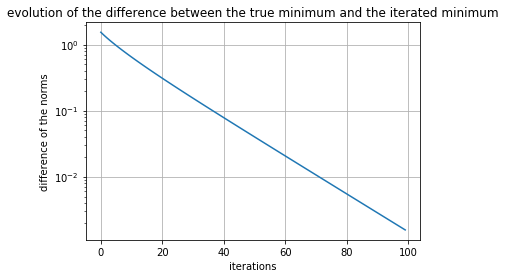

In [39]:
x_PGD = []
loss_PGD = []
iteration = 100
for i in range(iteration):
    print(i, end='\r')
    x_it, _, _ = PGD(x0, loss_logreg, grad_logreg,
                     L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                     lmbd, i, coefs, False)
    x_PGD.append(x_it)
    loss_PGD.append(loss_logreg(x_it))
iterations = np.arange(iteration)

true_loss = loss_logreg(x)
plt.plot(iterations,(loss_PGD-true_loss)**2)
plt.xlabel('iterations')
plt.ylabel('difference of the losses')
plt.yscale('log')
plt.grid()
plt.title('evolution of the difference between the true loss and the loss through iterations')
plt.show()

error_x = norm((x_PGD-x),2, axis = 1)
plt.xlabel('iterations')
plt.ylabel('difference of the norms')
plt.yscale('log')
plt.grid()
plt.title('evolution of the difference between the true minimum and the iterated minimum')
plt.plot(iterations, error_x)
plt.show()

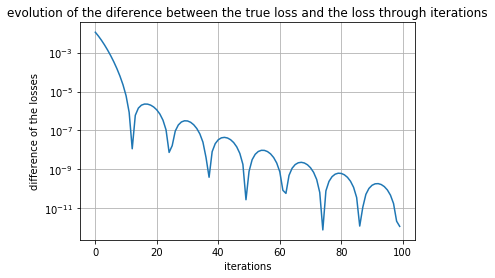

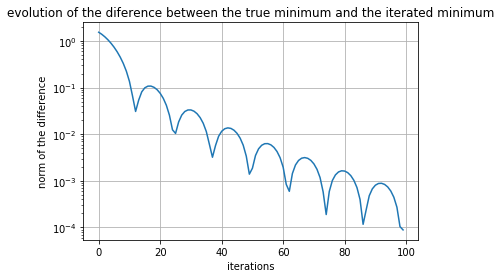

In [40]:
x_APGD = []
loss_APGD = []
for i in range(iteration):
    print(i, end='\r')
    x_it, _, _ = APGD(x0, loss_logreg, grad_logreg,
                     L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                     lmbd, i, coefs, False)
    x_APGD.append(x_it)
    loss_APGD.append(loss_logreg(x_it))

plt.plot(iterations,(loss_APGD-true_loss)**2)
plt.xlabel('iterations')
plt.ylabel('difference of the losses')
plt.yscale('log')
plt.grid()
plt.title('evolution of the diference between the true loss and the loss through iterations')
plt.show()

error_x = norm((x_APGD-x),2, axis = 1)
plt.xlabel('iterations')
plt.ylabel('norm of the difference')
plt.yscale('log')
plt.grid()
plt.title('evolution of the diference between the true minimum and the iterated minimum')
plt.plot(iterations, error_x)
plt.show()

<div class="alert alert-info">
We can see that the distance between the iterated minimizer and the actual minimizer is decreasing way faster with the AGPD algorithm than with the PGD algorithm.
</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

> *Compare the solution you obtain with ista and fista with the true parameter coefs of the model. This can be done with plt.stem plots.*

(-2, 2)

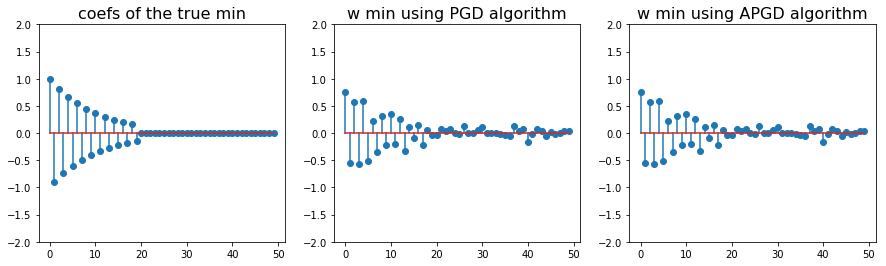

In [41]:
x_min_APGD, objectives_APGD, errors_APGD = APGD(x0, loss_logreg, grad_logreg,
                                                L2_norm, prox_L2, 1 /
                                                smoothness_const_logreg(A),
                                                lmbd, 1000, coefs, False)

x_min_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_logreg, grad_logreg,
                                            L2_norm, prox_L2, 1 /
                                            smoothness_const_logreg(A),
                                            lmbd, 1000, coefs, False)

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("coefs of the true min", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)

plt.stem(x_min_PGD)
plt.title("w min using PGD algorithm", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)

plt.stem(x_min_APGD)
plt.title("w min using APGD algorithm", fontsize=16)
plt.ylim([-2, 2])

> *In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.*

** Linear regression **
*APGD algorithm*

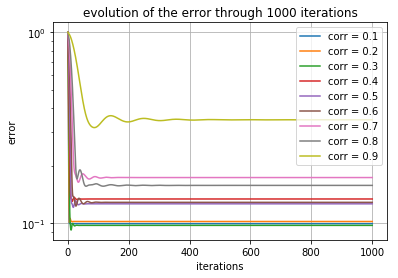

In [42]:
for i in range (1,10):
    A, b = simu_linreg(coefs, corr = i/10)
    x, objectives, errors = APGD(x0, loss_linreg, grad_linreg,
                             L2_norm, prox_L2, 1/smoothness_const_linreg(A),
                             lmbd, 1000, coefs, False)
    plt.plot(errors, label = 'corr = '+str(i/10))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the error through 1000 iterations')
plt.show()

** Linear regression **
*PGD algorithm*

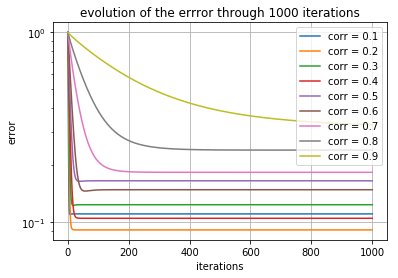

In [43]:
for i in range (1,10):
    A, b = simu_linreg(coefs, corr = i/10)
    x, objectives, errors = PGD(x0, loss_linreg, grad_linreg,
                             L2_norm, prox_L2, 1/smoothness_const_linreg(A),
                             lmbd, 1000, coefs, False)
    plt.plot(errors, label = 'corr = '+str(i/10))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the errror through 1000 iterations')
plt.show()

** Logistic regression **
*PGD algorithm*

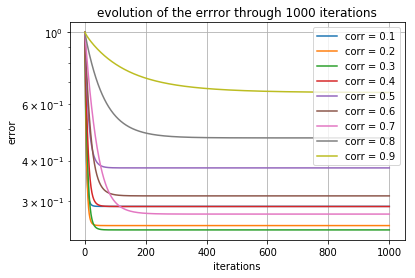

In [44]:
for i in range (1,10):
    A, b = simu_logreg(coefs, corr = i/10)
    x, objectives, errors = PGD(x0, loss_logreg, grad_logreg,
                             L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                             lmbd, 1000, coefs, False)
    plt.plot(errors, label = 'corr = '+str(i/10))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the errror through 1000 iterations')
plt.show()

** Logistic regression **
*APGD algorithm*

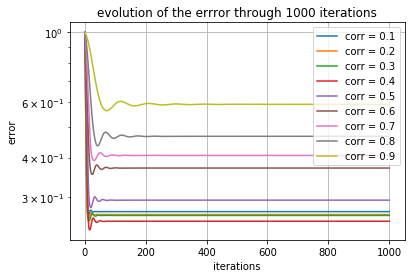

In [46]:
for i in range (1,10):
    print(i, end='\r')
    A, b = simu_logreg(coefs, corr = i/10)
    x, objectives, errors = APGD(x0, loss_logreg, grad_logreg,
                             L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                             lmbd, 1000, coefs, False)
    plt.plot(errors, label = 'corr = '+str(i/10))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the errror through 1000 iterations')
plt.show()

<div class="alert alert-info">
We can see with all the different regressions and algorithms that it is best to keep a small correlation coefficient (e.g. below 0.5)
</div>

> *In linear regression and logistic regression, study the influence of the level of L2 penalization on the performance of the optimization algorithms. Explain.*

**Linear regression** (AGPD)

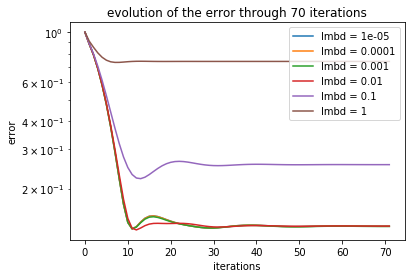

In [81]:
A, b = simu_linreg(coefs)
for i in range (-5,1):
    print(i, end='\r')
    x, objectives, errors = APGD(x0, loss_linreg, grad_linreg,
                             L2_norm, prox_L2, 1/smoothness_const_linreg(A),
                             10**i, 70, coefs, False)
    plt.plot(errors, label = 'lmbd = '+str(10**i))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the error through 70 iterations')
plt.show()

**Logistic regression** (AGPD)

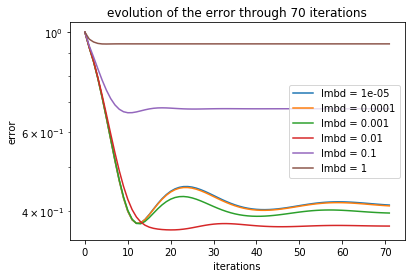

In [80]:
A, b = simu_logreg(coefs)
for i in range (-5,1):
    print(i, end='\r')
    x, objectives, errors = APGD(x0, loss_logreg, grad_logreg,
                             L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                             10**i, 70, coefs, False)
    plt.plot(errors, label = 'lmbd = '+str(10**i))
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('evolution of the error through 70 iterations')
plt.show()

<div class="alert alert-info">
In both cases it is best to keep $\lambda$ around 10e-2.
</div>

> In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain

**Linear regression** (AGPD)

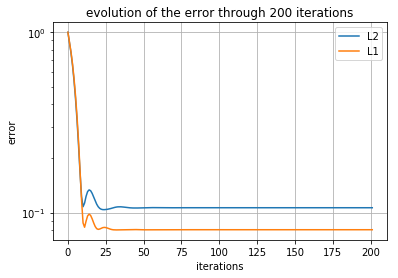

In [49]:
A, b = simu_linreg(coefs)
x, objectives, errors = APGD(x0, loss_linreg, grad_linreg,
                         L2_norm, prox_L2, 1/smoothness_const_linreg(A),
                         lmbd, 200, coefs, False)
plt.plot(errors, label = 'L2')
x, objectives, errors = APGD(x0, loss_linreg, grad_linreg,
                         L1_norm, prox_L1, 1/smoothness_const_linreg(A),
                         lmbd, 200, coefs, False)
plt.plot(errors, label = 'L1')
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('evolution of the error through 200 iterations')
plt.show()

**Logistic regression** (AGPD)

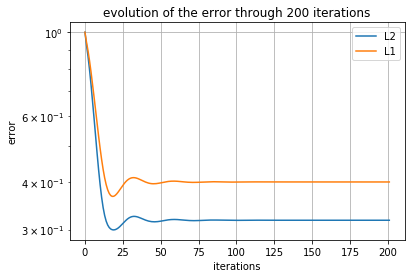

In [50]:
A, b = simu_logreg(coefs)
x, objectives, errors = APGD(x0, loss_logreg, grad_logreg,
                         L2_norm, prox_L2, 1/smoothness_const_logreg(A),
                         lmbd, 200, coefs, False)
plt.plot(errors, label = 'L2')
x, objectives, errors = APGD(x0, loss_logreg, grad_logreg,
                         L1_norm, prox_L1, 1/smoothness_const_logreg(A),
                         lmbd, 200, coefs, False)
plt.plot(errors, label = 'L1')
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('evolution of the error through 200 iterations')
plt.show()

<div class="alert alert-info">
For linear regression, L1 works best. This may be due to the fact that it sets many coefficients to zero.<br>
For logisitc regression, L2 works best.
</div>